# Session overview across protocols, with QC

In [1]:
prefix = '/home/ines/repositories/'
# prefix = '/Users/ineslaranjeira/Documents/Repositories/'

In [2]:
import os
import numpy as np
from one.api import ONE
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pandas as pd
from dateutil import parser
from datetime import datetime

# one = ONE(base_url='https://alyx.internationalbrainlab.org')
one = ONE(mode='remote')
one = ONE(
    base_url='https://alyx.internationalbrainlab.org',
    silent=True
)
# Get my functions
functions_path =  prefix + 'representation_learning_variability/Functions/'
os.chdir(functions_path)
from one_functions_generic import download_subjectTables


## Brainwide map query

In [3]:
base_query = (
    'session__projects__name__icontains,ibl_neuropixel_brainwide_01,'
    '~session__json__IS_MOCK,True,'
    'session__qc__lt,50,'
    'session__extended_qc__behavior,1,'
    '~json__qc,CRITICAL,'  # Should clarify these
    'json__extended_qc__alignment_count__gt,0,'  # No need for alignment resolved
)
qc_task = (
    '~session__extended_qc___task_stimOn_goCue_delays__lt,0.9,'
    '~session__extended_qc___task_response_feedback_delays__lt,0.9,'
    '~session__extended_qc___task_wheel_move_before_feedback__lt,0.9,'
    '~session__extended_qc___task_wheel_freeze_during_quiescence__lt,0.9,'
    '~session__extended_qc___task_error_trial_event_sequence__lt,0.9,'
    '~session__extended_qc___task_correct_trial_event_sequence__lt,0.9,'
    '~session__extended_qc___task_reward_volumes__lt,0.9,'
    '~session__extended_qc___task_reward_volume_set__lt,0.9,'
    '~session__extended_qc___task_stimulus_move_before_goCue__lt,0.9,'
    '~session__extended_qc___task_audio_pre_trial__lt,0.9')

marked_pass = (
    'session__extended_qc___experimenter_task,PASS')  # What is this?

insertions = list(one.alyx.rest('insertions', 'list', django=base_query + qc_task))
insertions.extend(list(one.alyx.rest('insertions', 'list', django=base_query + marked_pass)))
print(len(insertions))

bwm_df = pd.DataFrame({
    'pid': np.array([i['id'] for i in insertions]),
    'eid': np.array([i['session'] for i in insertions]),
    'probe_name': np.array([i['name'] for i in insertions]),
    'session_number': np.array([i['session_info']['number'] for i in insertions]),
    'date': np.array([parser.parse(i['session_info']['start_time']).date() for i in insertions]),
    'subject': np.array([i['session_info']['subject'] for i in insertions]),
    'lab': np.array([i['session_info']['lab'] for i in insertions]),
}).sort_values(by=['lab', 'subject', 'date', 'eid'])
bwm_df.drop_duplicates(inplace=True)
bwm_df.reset_index(inplace=True, drop=True)


746


## Pre-recording sessions

In [4]:
len(bwm_df.subject.unique())

144

In [5]:
def load_latest_working_aggregate(one, subject, base_name):
    """
    Try loading an aggregate starting from the highest revision,
    going backwards until one works.
    """
    aggs = one.list_aggregates('subjects', subject)

    # numeric revisions, newest → oldest
    revs = (aggs['revision'].dropna().sort_values(ascending=False))

    for rev in revs:
        try:
            return one.load_aggregate('subjects',subject,base_name,revision=rev)
        except Exception:
            continue

    raise RuntimeError(
        f'All revisions failed for {subject}: {base_name}')

def extended_qc(one, eids):
    # Initialize df
    df = pd.DataFrame()

    for e, eid in enumerate(eids):
        try:
            extended_qc = one.get_details(eid, True)['extended_qc']
            transposed_df = pd.DataFrame.from_dict(extended_qc, orient='index').T
            transposed_df['session'] = eid
            df = pd.concat([df, transposed_df])
        except:
            print(eid)
    return df

In [6]:
unique_mice = bwm_df['subject'].unique()
all_sessions = pd.DataFrame()

for subj in unique_mice:
     try:
          trials_table = load_latest_working_aggregate(one, subj, '_ibl_subjectTrials.table')
          training_table = load_latest_working_aggregate(one, subj, '_ibl_subjectTraining.table')

          session_info = trials_table[['task_protocol', 'session_start_time', 'session']].drop_duplicates()
          training_status = training_table.copy()
          session_info = session_info.merge(training_status, on='session', how='outer').sort_values(by='session_start_time')
          session_info['session_number'] = np.arange(0, len(session_info), 1)
          session_info['subject'] = subj

          all_sessions = pd.concat([all_sessions, session_info])
          
     except Exception as err:
          print(subj, err)


/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2024-08-02", "2024-04-11"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2024-08-02", "2024-04-11"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2024-04-11"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2024-04-11"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2024-08-21", "2024-04-11"
  warnings.warn(f'Multiple revisi

HB_005 All revisions failed for HB_005: _ibl_subjectTraining.table


/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2024-04-11"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2024-04-11"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2024-07-22"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2024-07-22"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2024-04-11"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home

NR_0023 All revisions failed for NR_0023: _ibl_subjectTraining.table


/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2024-07-22"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2024-07-22"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2024-04-11"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2024-04-11"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2024-07-22"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home

In [10]:
save_sessions = all_sessions.copy()

# Plot session overview

In [17]:
all_sessions['protocol_number'] = all_sessions['session_number'] * np.nan

all_sessions['task_protocol'] = all_sessions['task_protocol'].astype(str)
all_sessions.loc[(all_sessions['task_protocol'].str.contains('training')), 'protocol_number'] = 0
all_sessions.loc[(all_sessions['task_protocol'].str.contains('biased')), 'protocol_number'] = 1
all_sessions.loc[(all_sessions['task_protocol'].str.contains('ephys')), 'protocol_number'] = 2

all_sessions['training_status'] = all_sessions['training_status'].astype(str)
all_sessions.loc[(all_sessions['training_status'].str.contains('trained 1b')), 'protocol_number'] = 3
all_sessions.loc[(all_sessions['training_status'].str.contains('ready4ephysrig')), 'protocol_number'] = 4
all_sessions.loc[(all_sessions['training_status'].str.contains('ready4delay')), 'protocol_number'] = 5
all_sessions.loc[(all_sessions['training_status'].str.contains('ready4recording')), 'protocol_number'] = 6
all_sessions.loc[(all_sessions['training_status'].str.contains('unbiasable')), 'protocol_number'] = 7
all_sessions.loc[(all_sessions['training_status'].str.contains('untrainable')), 'protocol_number'] = 8

subjects = all_sessions['subject'].unique()
n_mice = len(subjects)
max_sessions = all_sessions['session_number'].max() + 1

protocol_matrix = np.full((n_mice, max_sessions), np.nan)
for i, subj in enumerate(subjects):
    subj_df = all_sessions[all_sessions['subject'] == subj]
    protocol_matrix[i, subj_df['session_number']] = subj_df['protocol_number']


In [18]:
from matplotlib.colors import to_rgb
# 1️⃣ Base colors
colors = [
    '#add8ff',  # light blue
    '#ffd8a8',  # light orange
    '#a8ffb0']  # light green

# 2️⃣ Purple gradient (4 colors, increasing strength)
purple_start = to_rgb('#d8b0ff')  # light purple
purple_end   = to_rgb('#4b0082')  # darkish purple

# interpolate 4 colors
for i in range(4):
    t = i / 3  # normalized 0 → 1
    r = purple_start[0] + t * (purple_end[0] - purple_start[0])
    g = purple_start[1] + t * (purple_end[1] - purple_start[1])
    b = purple_start[2] + t * (purple_end[2] - purple_start[2])
    colors.append((r, g, b))

# 3️⃣ Red colors
colors.append('#ff9999')  # light red
colors.append('#990000')  # dark red

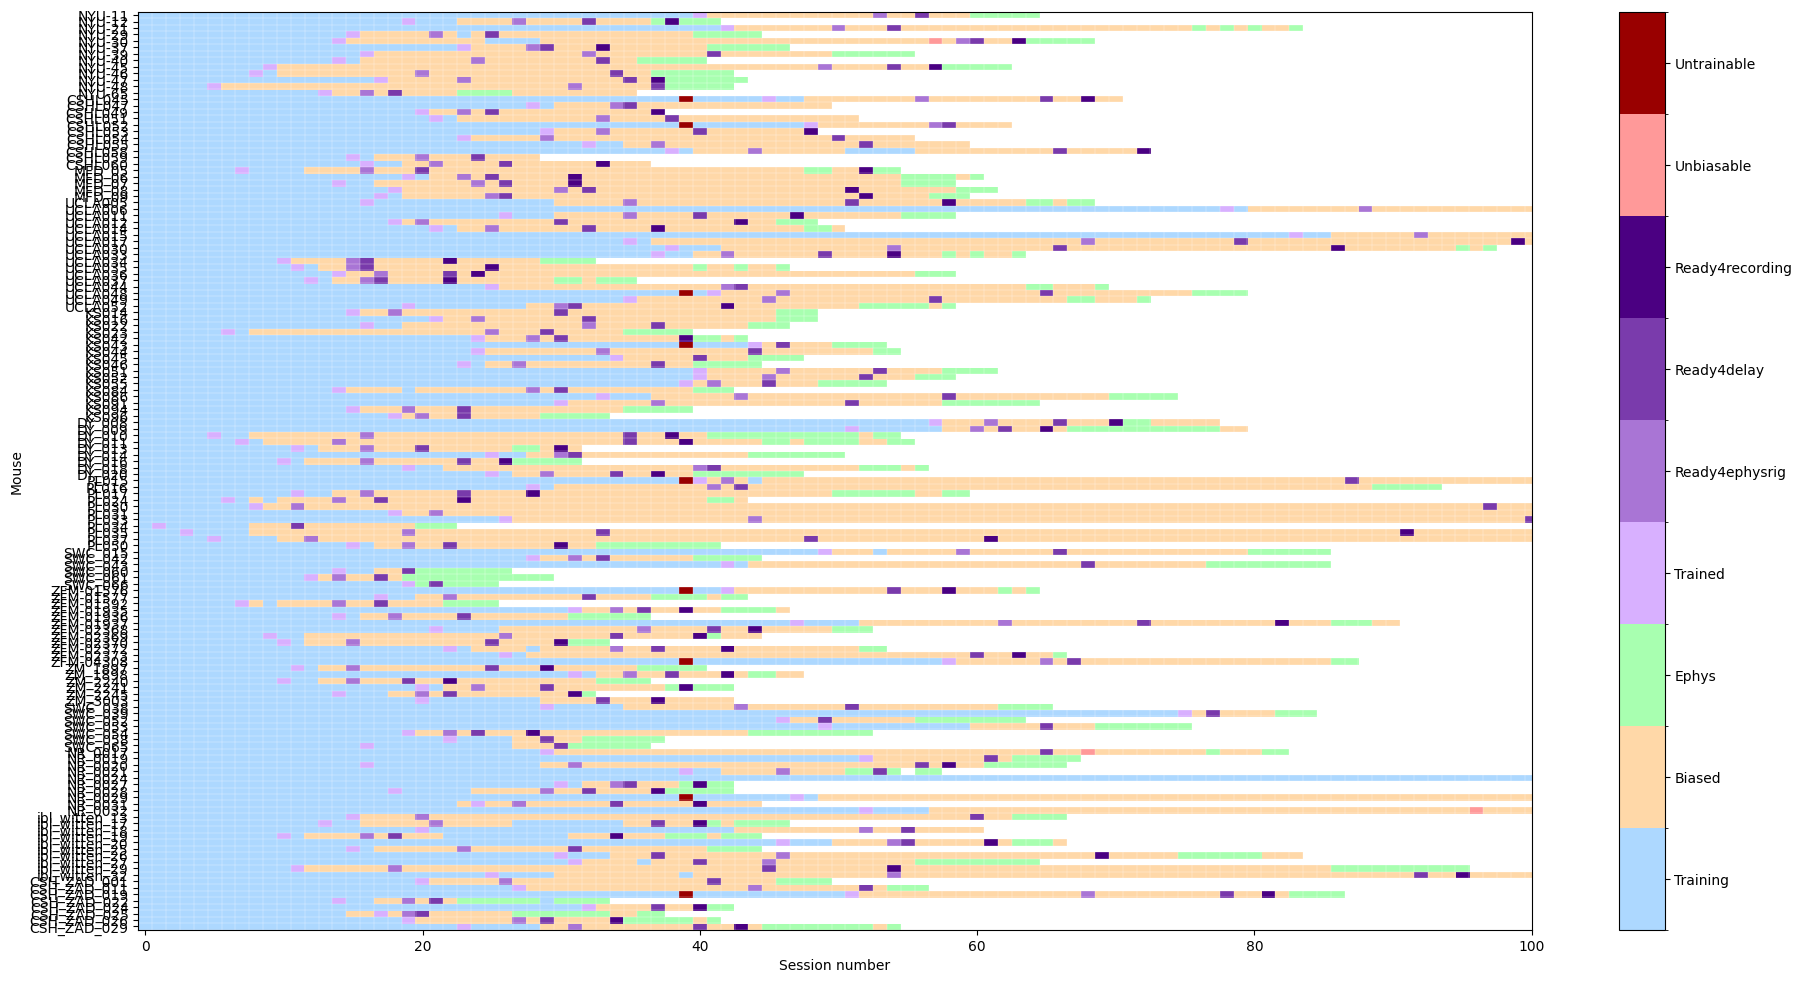

In [19]:
from matplotlib.colors import ListedColormap, BoundaryNorm

cmap = ListedColormap(colors)
# Training (green), Biased (blue), Ephys (red)
norm = BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5], cmap.N)
fig, ax = plt.subplots(figsize=(19, 0.07 * n_mice))
im = ax.imshow(protocol_matrix, aspect='auto', cmap=cmap, norm=norm)
ax.set_xlabel('Session number')
ax.set_ylabel('Mouse')
ax.set_yticks(np.arange(n_mice))
ax.set_yticklabels(subjects)

# Add thin white grid lines
ax.set_xticks(np.arange(-0.5, protocol_matrix.shape[1], 1), minor=True)
ax.set_yticks(np.arange(-0.5, protocol_matrix.shape[0], 1), minor=True)
ax.grid(which='minor', color='white', linestyle='-', linewidth=0.2)
ax.tick_params(which='minor', length=0)  # hide minor tick marks

# Colorbar with labels
cbar = plt.colorbar(im, ax=ax, ticks=[0, 1, 2, 3, 4, 5, 6, 7, 8])
cbar.ax.set_yticklabels(['Training', 'Biased', 'Ephys', 'Trained', 'Ready4ephysrig', 'Ready4delay', 'Ready4recording', 'Unbiasable', 'Untrainable'])

plt.xlim([-.5, 100])
# plt.ylim([-.5, 50.5])
plt.tight_layout()
plt.show()


## Load extended QC and save

In [ ]:
pro_sessions = all_sessions.loc[all_sessions['protocol_number'].isin([1, 2])]
len(pro_sessions.session.unique())

training_sessions = all_sessions.loc[all_sessions['protocol_number'].isin([0])]
len(training_sessions.session.unique())
biased_sessions = all_sessions.loc[all_sessions['protocol_number'].isin([1])]
len(biased_sessions.session.unique())
ephys_sessions = all_sessions.loc[all_sessions['protocol_number'].isin([2])]
len(ephys_sessions.session.unique())

675

In [ ]:
ephys_session_qc = extended_qc(one, ephys_sessions['session'].unique())
biased_session_qc = extended_qc(one, biased_sessions['session'].unique())
training_session_qc = extended_qc(one, training_sessions['session'].unique())

f8bed96d-3a6f-4e07-b4ff-f141c4aeaa20
251ece37-7798-477c-8a06-2845d4aa270c
cdcba3dc-dd35-4dec-9a90-19e31f4b9d0b
73654e36-9546-463f-8cdf-df6b6e477054
c0ba910e-3e8b-4596-b509-0e28a15c332b
1114aa6e-a49b-4de7-9a9b-e6fc48ca5d46
468d2123-fbdc-4b8d-bcd2-c72bf345e408
9a926b27-6801-4fa4-a362-ebe916ee9009
b9b8fa2a-8949-4f79-ab6a-c90a3d068b55
f55e0699-ebc3-447e-a4ff-d0ecf73f3018
aed565c2-8f5b-433f-bd30-ed45aedc33a0
6dda1b46-afe3-48ee-918b-c308ba7dd519
1e6c2fed-8e6f-4ff6-b3ff-b982425ed8c6
9ecc2335-9a23-40c2-ae0b-c4087818bfd6
94535612-5064-40aa-aa05-8c08c2fa618a
e65de8fe-5b69-48fb-81d9-10abda28c3a6
8028df72-7f65-4609-9e6a-354f08648ae1
1c5ae8dc-edd4-4ebd-9883-3d8fea79804f
6ec717b1-a8ac-466a-8a71-01c652ae7cce
21d3bbdf-7cb1-4a86-bd7d-16d88c0e38b1
d383b2b7-cb1a-4f25-a101-8e9dffc75a2c
5cc6aeb7-f1e8-4e23-a286-1345d9883518
0cf783d4-770a-4953-92bb-5de03f3b389e
faff72fd-a15f-4b12-9f65-7746ae51be61
b84a61d2-8e1e-461a-bff1-16b44dc6cea3
ef924b7f-fa72-4afd-9fe8-4186ee5ed4f9
55cbc068-dc37-4e5a-85dc-c7763b508049
f

In [ ]:
functions_path =  prefix + 'representation_learning_variability/Video and wheel/Video QC/'
training_session_qc.to_csv(functions_path+'training_sessions_extended_qc', compression={'method': 'gzip'})

In [20]:
functions_path =  prefix + 'representation_learning_variability/Video and wheel/Video QC/'
ephys_session_qc = pd.read_csv(functions_path+"ephys_sessions_extended_qc", compression={'method': 'gzip'})
biased_session_qc = pd.read_csv(functions_path+"biased_sessions_extended_qc", compression={'method': 'gzip'})
training_session_qc = pd.read_csv(functions_path+"training_sessions_extended_qc", compression={'method': 'gzip'})

# Plot session overview with QC

In [12]:
def use_qc(new_df):
    
    rec_qc_pass = new_df.loc[
                            (new_df['task'].isin(['PASS', 'WARNING'])) &
                            # (new_df['_videoLeft_pin_state'].apply(lambda x: (isinstance(x, list) and True in x) or x == 'PASS')) &
                            # (new_df['_videoLeft_framerate'].apply(lambda x: (isinstance(x, list) and True in x) or x == 'PASS')) &   
                            (new_df['_videoLeft_camera_times'].apply(lambda x: (isinstance(x, list) and True in x) or x == 'PASS')) & 
                            (new_df['_videoLeft_dropped_frames'].apply(lambda x: (isinstance(x, list) and True in x) or x == 'PASS')) &   # can make more conservative by removing or  x == None
                            # (new_df['lightningPoseLeft'].isin(['PASS', 'FAIL'])) &
                            # (new_df['_lightningPoseLeft_lick_detection'].isin(['PASS'])) &
                            # (new_df['_lightningPoseLeft_time_trace_length_match'].isin(['PASS'])) &   
                            # (new_df['_lightningPoseLeft_trace_all_nan'].isin(['PASS'])) &
                            # (new_df['_lightningPoseLeft_mean_in_bbox'].isin(['PASS'])) &
                            (new_df['_videoLeft_timestamps'].isin([True, 'PASS'])) &
                            # (new_df['_videoRight_pin_state'].apply(lambda x: (isinstance(x, list) and True in x) or x == 'PASS')) &
                            # (new_df['_videoRight_framerate'].apply(lambda x: (isinstance(x, list) and True in x) or x == 'PASS')) &   
                            (new_df['_videoRight_camera_times'].apply(lambda x: (isinstance(x, list) and True in x) or x == 'PASS')) & 
                            (new_df['_videoRight_dropped_frames'].apply(lambda x: (isinstance(x, list) and True in x) or x == 'PASS')) &   # can make more conservative by removing or  x == None
                            # (new_df['lightningPoseRight'].isin(['PASS', 'FAIL'])) 
                            # (new_df['_lightningPoseRight_lick_detection'].isin(['PASS'])) &
                            # (new_df['_lightningPoseRight_time_trace_length_match'].isin(['PASS'])) &   
                            # (new_df['_lightningPoseRight_trace_all_nan'].isin(['PASS'])) &
                            # (new_df['_lightningPoseRight_mean_in_bbox'].isin(['PASS'])) &
                            (new_df['_videoRight_timestamps'].isin([True, 'PASS']))
                            ]
    
                            # (new_df['_lightningPoseLeft_lick_detection'].isin(['PASS'])) &
                            # (new_df['_lightningPoseLeft_time_trace_length_match'].isin(['PASS'])) &   
                            # (new_df['_lightningPoseLeft_trace_all_nan'].isin(['PASS'])) &

    new_df.loc[new_df['session'].isin(rec_qc_pass['session'].unique()), 'qc'] = 1
    return new_df


In [45]:
def use_qc(new_df):
    
    rec_qc_pass = new_df.loc[
                        (new_df['task'].isin(['PASS', 'WARNING'])) &
                        (new_df['_videoLeft_camera_times'].apply(lambda x: x == 'PASS' or ('True' in str(x)))) & 
                        (new_df['_videoLeft_dropped_frames'].apply(lambda x: x == 'PASS' or ('True' in str(x)))) &   # can make more conservative by removing or  x == None
                        (new_df['_videoLeft_timestamps'].isin(['True', 'PASS'])) 
                        # (new_df['_videoLeft_pin_state'].apply(lambda x: x == 'PASS' or ('True' in str(x)))) & 
                        # (new_df['_videoLeft_framerate'].apply(lambda x: x == 'PASS' or ('True' in str(x)))) & 

                        # (new_df['_videoRight_camera_times'].apply(lambda x: x == 'PASS' or ('True' in str(x)))) & 
                        # (new_df['_videoRight_dropped_frames'].apply(lambda x: x == 'PASS' or ('True' in str(x)))) &   # can make more conservative by removing or  x == None
                        # (new_df['_videoRight_timestamps'].isin(['True', 'PASS'])) 
                        # (new_df['_videoRight_framerate'].apply(lambda x: x == 'PASS' or ('True' in str(x)))) & 
                        # (new_df['_videoRight_pin_state'].apply(lambda x: x == 'PASS' or ('True' in str(x))))
                            ]

    new_df.loc[new_df['session'].isin(rec_qc_pass['session'].unique()), 'qc'] = 1
    return new_df


In [38]:
# QC for my project

""" rec_qc_pass = rec_qc.loc[(rec_qc['task'].isin(['PASS', 'WARNING'])) &
                         (rec_qc['_lightningPoseLeft_lick_detection'].isin(['PASS'])) &
                         (rec_qc['_lightningPoseLeft_time_trace_length_match'].isin(['PASS'])) &   
                         (rec_qc['_lightningPoseLeft_trace_all_nan'].isin(['PASS'])) &
                         (rec_qc['_videoLeft_pin_state'].apply(lambda x: (isinstance(x, list) and True in x) or x == 'PASS')) &
                         (rec_qc['_videoLeft_framerate'].apply(lambda x: (isinstance(x, list) and True in x) or x == 'PASS')) &   
                         (rec_qc['_videoLeft_camera_times'].apply(lambda x: (isinstance(x, list) and True in x) or x == 'PASS')) &   
                         (rec_qc['_videoLeft_dropped_frames'].apply(lambda x: (isinstance(x, list) and True in x) or x == 'PASS')) &  # can make more conservative by removing or  x == None
                         (rec_qc['_videoLeft_timestamps'].isin([True, 'PASS']))]
                         """

" rec_qc_pass = rec_qc.loc[(rec_qc['task'].isin(['PASS', 'WARNING'])) &\n                         (rec_qc['_lightningPoseLeft_lick_detection'].isin(['PASS'])) &\n                         (rec_qc['_lightningPoseLeft_time_trace_length_match'].isin(['PASS'])) &   \n                         (rec_qc['_lightningPoseLeft_trace_all_nan'].isin(['PASS'])) &\n                         (rec_qc['_videoLeft_pin_state'].apply(lambda x: (isinstance(x, list) and True in x) or x == 'PASS')) &\n                         (rec_qc['_videoLeft_framerate'].apply(lambda x: (isinstance(x, list) and True in x) or x == 'PASS')) &   \n                         (rec_qc['_videoLeft_camera_times'].apply(lambda x: (isinstance(x, list) and True in x) or x == 'PASS')) &   \n                         (rec_qc['_videoLeft_dropped_frames'].apply(lambda x: (isinstance(x, list) and True in x) or x == 'PASS')) &  # can make more conservative by removing or  x == None\n                         (rec_qc['_videoLeft_timestamps'].isin(

In [46]:
all_sessions = save_sessions.copy()

full_qc = pd.concat([training_session_qc, biased_session_qc, ephys_session_qc])
full_qc['qc'] = 0
new_df = all_sessions.merge(full_qc, on=['session'], how='left')
new_df = use_qc(new_df)

# # Find sessions which (1) have two cameras, (2) pass basic left and right QC AND (3) don't have LP yet (this depends on date of last run)
# to_check = new_df.loc[(new_df['qc']==1) & (new_df['lightningPoseRight']!='PASS')& 
#                       (new_df['lightningPoseLeft']!='PASS') &
#                       (new_df['lightningPoseLeft']!='FAIL')] #[['session', 'subject','lightningPoseLeft', 'lightningPoseRight']]



/tmp/ipykernel_11938/3665911507.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  full_qc['qc'] = 0


In [47]:
new_df['task_protocol'] = new_df['task_protocol'].astype(str)
new_df.loc[(new_df['task_protocol'].str.contains('training')), 'protocol_number'] = 0
new_df.loc[(new_df['task_protocol'].str.contains('biased')), 'protocol_number'] = 1
new_df.loc[(new_df['task_protocol'].str.contains('ephys')), 'protocol_number'] = 9

new_df['training_status'] = new_df['training_status'].astype(str)
new_df.loc[(new_df['training_status'].str.contains('trained 1b')), 'protocol_number'] = 3
new_df.loc[(new_df['training_status'].str.contains('ready4ephysrig')), 'protocol_number'] = 4
new_df.loc[(new_df['training_status'].str.contains('ready4delay')), 'protocol_number'] = 5
new_df.loc[(new_df['training_status'].str.contains('ready4recording')), 'protocol_number'] = 6
new_df.loc[(new_df['training_status'].str.contains('unbiasable')), 'protocol_number'] = 7
new_df.loc[(new_df['training_status'].str.contains('untrainable')), 'protocol_number'] = 8

new_df.loc[new_df['qc']==0, 'protocol_number'] = 9
subjects = new_df['subject'].unique()
n_mice = len(subjects)
max_sessions = new_df['session_number'].max() + 1

protocol_matrix = np.full((n_mice, max_sessions), np.nan)
for i, subj in enumerate(subjects):
    subj_df = new_df[new_df['subject'] == subj]
    protocol_matrix[i, subj_df['session_number']] = subj_df['protocol_number']

In [48]:
# 1️⃣ Base colors
colors = [
    '#add8ff',  # light blue
    '#ffd8a8',  # light orange
    '#a8ffb0']  # light green

# 2️⃣ Purple gradient (4 colors, increasing strength)
purple_start = to_rgb('#d8b0ff')  # light purple
purple_end   = to_rgb('#4b0082')  # darkish purple

# interpolate 4 colors
for i in range(4):
    t = i / 3  # normalized 0 → 1
    r = purple_start[0] + t * (purple_end[0] - purple_start[0])
    g = purple_start[1] + t * (purple_end[1] - purple_start[1])
    b = purple_start[2] + t * (purple_end[2] - purple_start[2])
    colors.append((r, g, b))

# 3️⃣ Red colors
colors.append('#ff9999')  # light red
colors.append('#990000')  # dark red
colors.append('#990000')  # dark red
colors.append('#808080')  # medium grey

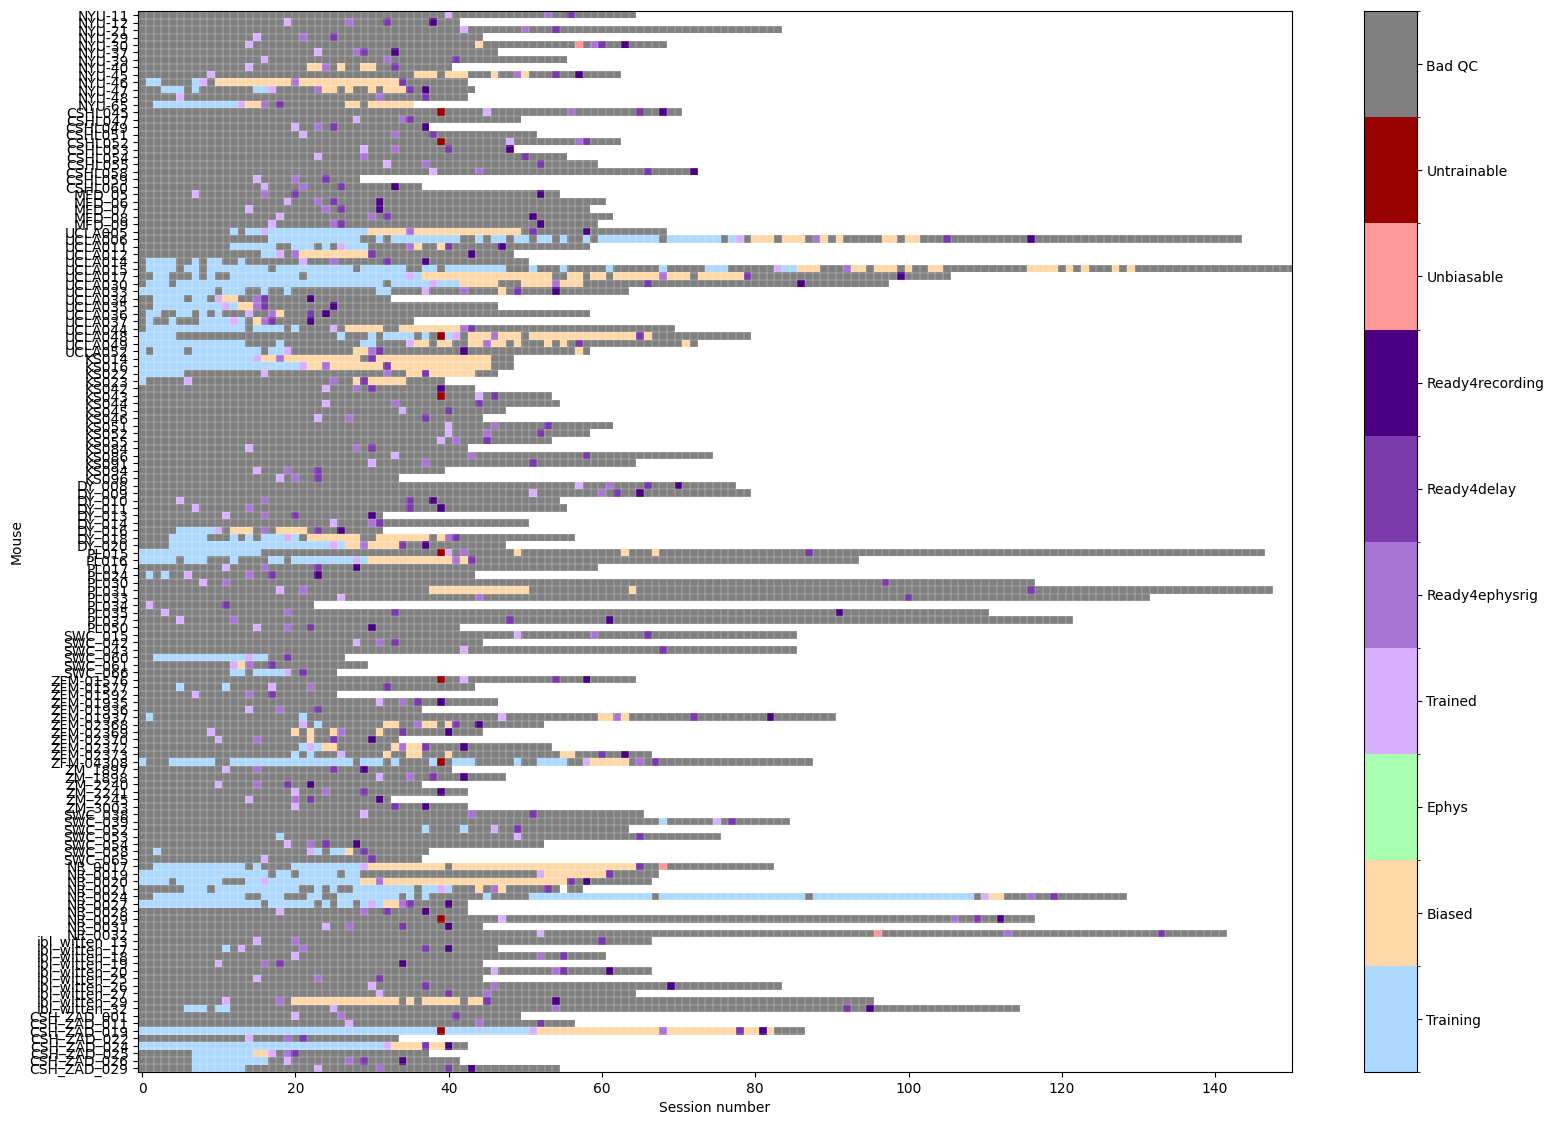

In [49]:
from matplotlib.colors import ListedColormap, BoundaryNorm

cmap = ListedColormap(colors)
# Training (green), Biased (blue), Ephys (red)
norm = BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5], cmap.N)
fig, ax = plt.subplots(figsize=(16, 0.08 * n_mice))
im = ax.imshow(protocol_matrix, aspect='auto', cmap=cmap, norm=norm)
ax.set_xlabel('Session number')
ax.set_ylabel('Mouse')
ax.set_yticks(np.arange(n_mice))
ax.set_yticklabels(subjects)

# Add thin white grid lines
ax.set_xticks(np.arange(-0.5, protocol_matrix.shape[1], 1), minor=True)
ax.set_yticks(np.arange(-0.5, protocol_matrix.shape[0], 1), minor=True)
ax.grid(which='minor', color='white', linestyle='-', linewidth=0.2)
ax.tick_params(which='minor', length=0)  # hide minor tick marks

# Colorbar with labels
cbar = plt.colorbar(im, ax=ax, ticks=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
cbar.ax.set_yticklabels(['Training', 'Biased', 'Ephys', 'Trained', 'Ready4ephysrig', 'Ready4delay', 'Ready4recording', 'Unbiasable', 'Untrainable', 'Bad QC'])

plt.xlim([-.5, 150])
# plt.ylim([-.5, 50.5])
plt.tight_layout()
plt.show()


In [ ]:
print(len(new_df.loc[new_df['qc']==1, 'subject'].unique()))
print(len(new_df.loc[new_df['qc']==1, 'session'].unique()))


78
314


# Extend BWM dataset with 3 cameras

In [102]:
def use_qc(new_df):
    rec_qc_pass = new_df.loc[
                        (new_df['task'].isin(['PASS', 'WARNING'])) &
                        (new_df['_videoLeft_camera_times'].apply(lambda x: x == 'PASS' or ('True' in str(x)))) & 
                        (new_df['_videoLeft_dropped_frames'].apply(lambda x: x == 'PASS' or ('True' in str(x)))) &   # can make more conservative by removing or  x == None
                        (new_df['_videoLeft_timestamps'].isin(['True', 'PASS'])) &
                        (new_df['_videoLeft_pin_state'].apply(lambda x: x == 'PASS' or ('True' in str(x)))) & 
                        (new_df['_videoLeft_framerate'].apply(lambda x: x == 'PASS' or ('True' in str(x)))) & 

                        (new_df['_videoRight_camera_times'].apply(lambda x: x == 'PASS' or ('True' in str(x)))) & 
                        (new_df['_videoRight_dropped_frames'].apply(lambda x: x == 'PASS' or ('True' in str(x)))) &   # can make more conservative by removing or  x == None
                        (new_df['_videoRight_timestamps'].isin(['True', 'PASS'])) &
                        (new_df['_videoRight_framerate'].apply(lambda x: x == 'PASS' or ('True' in str(x)))) & 
                        (new_df['_videoRight_pin_state'].apply(lambda x: x == 'PASS' or ('True' in str(x))))
                            ]
    new_df.loc[new_df['session'].isin(rec_qc_pass['session'].unique()), 'qc'] = 1
    return new_df
all_sessions = save_sessions.copy()

full_qc = pd.concat([training_session_qc, biased_session_qc, ephys_session_qc])
full_qc['qc'] = 0
new_df = all_sessions.merge(full_qc, on=['session'], how='left')
new_df = use_qc(new_df)

# Find sessions which (1) have two cameras, (2) pass basic left and right QC AND (3) don't have LP yet (this depends on date of last run)
to_check = new_df.loc[(new_df['qc']==1) & (new_df['lightningPoseRight']!='PASS')& 
                      (new_df['lightningPoseLeft']!='PASS') &
                      (new_df['lightningPoseLeft']!='FAIL')] #[['session', 'subject','lightningPoseLeft', 'lightningPoseRight']]
extended_subjects = to_check.subject.unique()
print(len(extended_subjects))


43


/tmp/ipykernel_10929/107579157.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  full_qc['qc'] = 0


In [75]:
import pickle
""" Load BWM data post-QC """
prefix = '/home/ines/repositories/'
# prefix = '/Users/ineslaranjeira/Documents/Repositories/'
data_path = prefix + '/representation_learning_variability/paper-individuality/0_pre-processing/'
filename = '1_bwm_qc_07-10-2025'

# data_path = prefix + 'representation_learning_variability/Video and wheel/Video QC/'
# filename = 'final_lp_qc07-10-2025'

bwm_query = pickle.load(open(data_path+filename, "rb"))

/tmp/ipykernel_10929/59134543.py:11: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  bwm_query = pickle.load(open(data_path+filename, "rb"))


In [108]:
my_sess = list(bwm_query.eid)
my_mice = new_df.loc[new_df['session'].isin(my_sess), 'subject'].unique()
sessions_overlapping_mice = to_check.loc[to_check['subject'].isin(my_mice)]
reduced = sessions_overlapping_mice[['subject', 
          '_videoLeft_pin_state', '_videoLeft_framerate', '_videoLeft_camera_times', '_videoLeft_dropped_frames', '_videoLeft_timestamps']]

In [122]:
functions_path =  prefix + 'representation_learning_variability/Video and wheel/Video QC/'
sessions_LP_ines = pd.read_parquet(functions_path+'sessions_LP_ines')

In [140]:
already_processed = np.intersect1d(np.array(sessions_LP_ines['session_1'].dropna()), np.array(sessions_overlapping_mice['session']))
for_LP_processing = np.array(sessions_overlapping_mice.loc[~sessions_overlapping_mice['session'].isin(already_processed), 'session'])

In [146]:
np.save('sessions_LP_ines_26012026', for_LP_processing)